**Introduction**


Trip Advisor is one the most popular and prominent online travel platform across the globe. However, there has been some significant criticsms received from its customers, causing a very hard challenges for them against the competetors like Airbnb, booking.com, Google Travel. This dissatisfaction from the customers has caused remarkable decline in the customers and business profit. As a Data Scientist of Trip Advisor, I have been assigned the task of analyising the review and rating from its Global Customers. Here I will be performing Sentiment Analysis of the customer reviews and making predictions on the rating based on the customer reviews by building a NLP pipeline.

Dataset Source: Kaggle

Link: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

**1) Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

import nltk
import re
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler



**2) Data Exploration and Cleaning**

In [ ]:
df = pd.read_csv('trip_advisor_reviews.csv')
df.sample(5)

,Review,Rating
17214,"exceeded expectations, friends philly nj ny va...",5
13242,awesome hotel loved decor argonaut san fran ex...,5
5695,good location recommended stayed 23rd-26th feb...,4
1932,"excellent price nice place, convenient downtow...",4
9056,terrific location great room just returned tri...,4


In [ ]:
df.shape

(20491, 2)

In [ ]:
df.isnull().sum()

,0
Review,0
Rating,0


In [ ]:
df.duplicated().sum()

0

**3) Visualization**

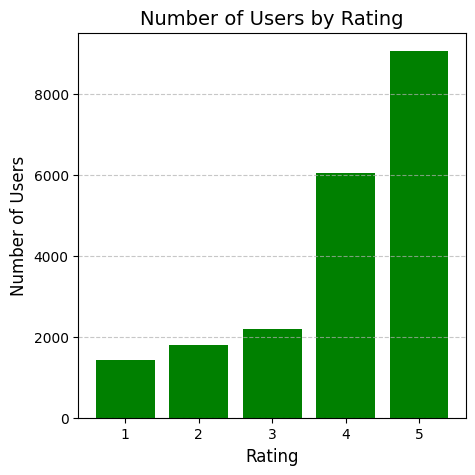

In [ ]:
#Visualisation of ratings
rating_counts = df['Rating'].value_counts()

plt.figure(figsize=(5, 5))
plt.bar(rating_counts.index, rating_counts.values, color='green')
plt.title('Number of Users by Rating', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rating_counts.index, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

From the above visulization we can see that majority of the customer has provided 5 star rating for the services of Trip Advisor. However, there could be cases where a customer has provided a high rating but the has expressed a little dissatisfying review and vice versa. In order to find this, we will now analyse the key words for the reviews that are greater than 2.5 and the reviews less than 2.

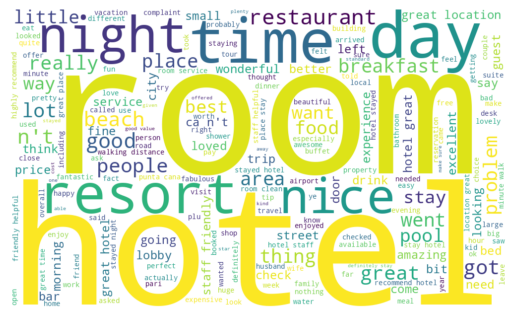

In [ ]:
#Check for positive and negative review words

#Check for Positive Review words

df_positive = df[df['Rating'] >= 2.5]
reviews_str = ' '.join(df_positive['Review'].astype(str).values)
wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words=200, contour_width=4, contour_color='steelred')
wordcloud.generate(reviews_str)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

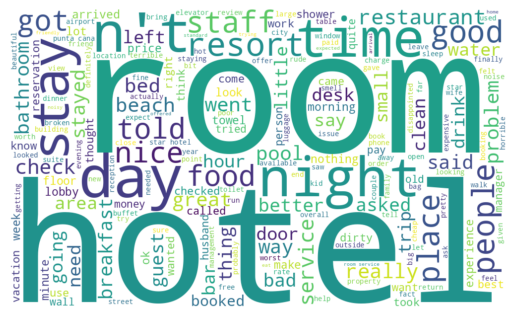

In [ ]:
#Check for Negative Review words

df_negative = df[df['Rating'] <= 2]
reviews_str = ' '.join(df_negative['Review'].astype(str).values)
wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words=200, contour_width=4, contour_color='steelred')
wordcloud.generate(reviews_str)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From the above visualizations we can observe that there are mixture of positive and negative words for the reviews whose ratings are less than 2. From this we can conclude that we need to perform Sentiment Analysis for a deeper study of Customer Reviews.

**4) Data Preprocessing**

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Data cleaning
def clean_text(text):
    # Initializing tools
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    #Lowercasing
    text = text.lower()

    #Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)

    #Removing numbers
    text = re.sub(r'\d+', '', text)

    #Removing special characters (non-alphanumeric)
    text = re.sub(r'\W', ' ', text)

    #Tokenization
    tokens = word_tokenize(text)

    #Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    #Lemmatization
    cleaned_words = [lemmatizer.lemmatize(word) for word in tokens]

    #Removing extra whitespace
    cleaned_text = " ".join(cleaned_words)

    #Removing URLs (if any are present)
    cleaned_text = re.sub(r'http\S+|www\S+', '', cleaned_text)

    return cleaned_text

# Cleaning the "review" column
df['Review_clean'] = df['Review'].dropna().apply(clean_text)


In [ ]:
df.sample(5)

,Review,Rating,Review_clean
12471,not grand paradise arrival-we recently stayed ...,1,grand paradis arrivalw recent stay grand parad...
3132,"honeymoon heaven, husband just returned honeym...",5,honeymoon heaven husband return honeymoon meli...
15874,"service door place gem, great location want re...",5,servic door place gem great locat want real ne...
12162,high quality hotel not stayed sheraton park cl...,4,high qualiti hotel stay sheraton park close de...
18972,just ok hotel granados 83 luxurious copy hotel...,3,ok hotel granado luxuri copi hotel urban madri...


**5) Sentiment Analysis**

5.1) Vectorization

In [ ]:
#Vectorization of words using TF-IDF method

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['Review_clean'])


In [ ]:
df['Sentiment'] = ['positive' if rating >= 2.5 else 'negative' for rating in df['Rating']]
df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'negative': 0})


5.2) Splitting data into Train and Test sets

In [ ]:
X = df['Review_clean']
y = df['Sentiment']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5.3) Fit and transform Training and Test Data

In [ ]:
# Fit and transform the training data, transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


**6) Model Creation**

i) Logistic Regeression

In [ ]:
# Initialize Logistic Regression
lr_model = LogisticRegression()

# Train the model
lr_model.fit(X_train_tfidf, y_train)
y_pred = lr_model.predict(X_train_tfidf)

#Accuracy
lr_accuracy = lr_model.score(X_train_tfidf, y_train)
print(f"LR Accuracy: {100*lr_accuracy:.2f}%")

LR Accuracy: 94.56%


ii) Naive Bayes

In [ ]:
#Initialize Naive Bayes
nb_model = MultinomialNB()

#Train the model
nb_model.fit(X_train_tfidf, y_train)
y_pred = nb_model.predict(X_train_tfidf)

#Accuracy
nb_accuracy = nb_model.score(X_train_tfidf, y_train)
print(f"NB Accuracy: {100*nb_accuracy:.2f}%")


NB Accuracy: 91.15%


iii) SVM

In [ ]:
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_train_tfidf)
svm_accuracy = svm_model.score(X_train_tfidf, y_train)
print(f"SVM Accuracy: {100*svm_accuracy:.2f}%")

SVM Accuracy: 97.89%


Logistic Regression and SVM shows a very high accuracy on the test sets. So we will apply SVM Model on our Test set.

In [ ]:
#Apply on test set
y_pred = svm_model.predict(X_test_tfidf)
svm_test_accuracy = svm_model.score(X_test_tfidf, y_test)

print(f"LR Accuracy: {100*svm_test_accuracy:.2f}%\n")

# Changed X_test_tfidf to y_test in classification_report
print(classification_report(y_test, y_pred))

LR Accuracy: 92.88%

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       625
           1       0.95      0.97      0.96      3474

    accuracy                           0.93      4099
   macro avg       0.87      0.84      0.86      4099
weighted avg       0.93      0.93      0.93      4099



**7) Prediction of Sentiment Analysis from the Customer Review**

In [ ]:
# Predict sentiment for the entire dataset
df['Sentiment_Predicted'] = svm_model.predict(vectorizer.transform(df['Review_clean']))

# Mapoing numerical sentiment predictions to labels
sentiment_map = {1: 'Positive', 0: 'Negative'}
df['Sentiment_Predicted_Label'] = df['Sentiment_Predicted'].map(sentiment_map)

sample_df = df.sample(n=2, random_state=42)

# Print the reviews with their predicted sentiment analysis result
for index, row in sample_df.iterrows():
    print(f"Review: {row['Review']}")
    print(f"Predicted Sentiment: {row['Sentiment_Predicted_Label']}")
    print("-" * 50)

Review: not recommend hotel did reviewers actually stay hotel did, good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got, disgusting, staff rude complained left night early refused refund night, not recommend hotel,  
Predicted Sentiment: Negative
--------------------------------------------------
Review: barcelona rocks, stayed hotel jazz girlfriend 3 nights end august.the hotel excellent location carrer pelai, close placa catalunya ramblas appreciate buzz city removed respite mayhem crowds, caught airport bus barcelona costs 7 euros person return trip, hotel located 2 mins walk maximum placa universitat stop 2nd route, hotel modern clean, air conditioning room superb balcony looking street outside, room good size, bathroom fine scrimp bit toiletries, bring shower gels unless consider washing unnecessary luxury travels.the downside hotel possibly strengths depending viewpoint, hotel 

**8) Prediction of Ratings from Customer Review**

In [ ]:
X = df['Review_clean']
y = df['Rating']

# Split into train and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#Applying Vectorization - TF-DF Vectorization

tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2), min_df=2, max_df=0.85)

# Fit and transform the text data
X_train_tfidf_r = tfidf.fit_transform(X_train_r).toarray()
X_test_tfidf_r = tfidf.transform(X_test_r).toarray()


In [ ]:
#Apply model and training

model = LogisticRegression(max_iter=500, solver='saga')
model.fit(X_train_tfidf_r, y_train_r)

# Predictions on Training set
y_pred = model.predict(X_train_tfidf_r)

#Accuracy
model_accuracy = model.score(X_train_tfidf_r, y_train_r)
print(f"Accuracy: {100*model_accuracy:.2f}%")



Accuracy: 76.80%


In [ ]:
#Applying Test set on the model

y_pred_r = model.predict(X_test_tfidf_r)
model_test_accuracy = model.score(X_test_tfidf_r, y_test_r)

print(f"LR Accuracy: {100*model_test_accuracy:.2f}%\n")

print(classification_report(y_test_r, y_pred_r))


LR Accuracy: 63.21%

              precision    recall  f1-score   support

           1       0.78      0.64      0.70       292
           2       0.48      0.41      0.44       333
           3       0.41      0.23      0.30       432
           4       0.55      0.51      0.53      1252
           5       0.71      0.85      0.77      1790

    accuracy                           0.63      4099
   macro avg       0.59      0.53      0.55      4099
weighted avg       0.61      0.63      0.62      4099



**9) Conclusion**

In this experiment we perform Sentiment Analysis of the review from the global customers of Trip Advisor. We applied the NLP Text cleaning process on the feature 'Review'. Then we also performed Vectorization of the text and prediction of sentiment analysis and rating based on the reviews after cleaning. We have obtained a very high accuracy for our Model for Sentiment Analysis and an average accuracy score for the model to predict the Rating from Reviews.

**Recommendations**

The dataset used for the study contains very limited features (Rating and Review). Having an addtional fetures like Review Title, Published date or date of review, Area of negative review (Hotel, Food, Booking, Customer Service, payment mode, type of customer) would have given a broad idea for the business to re-organize and refurbish the business operations. In addition, the model for prediction of Rating has only an average Accuracy score. Using advanced techinques or building a complex model help in improving this accuracy.